<a href="https://colab.research.google.com/github/Ayonator77/Alpha-Pilot/blob/master/MultiScaleLossGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import easydict
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from scipy.ndimage.filters import gaussian_filter1d
# import torch_xla
# import torch_xla.core.xla_model as xm

In [ ]:
# import os
# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
input_size = 784

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(input_size, 1000)
    self.fc2 = nn.Linear(1000, 500)
    self.fc3 = nn.Linear(500, 10)
    self.R1_par = nn.Parameter(1*torch.ones(1), requires_grad=True)
    self.R2_par = nn.Parameter(10*torch.ones(1), requires_grad=True)

  def forward(self, x, target, eta, i, g, R):
    g = (1-g) * (self.R1_par) + (g*(self.R2_par))
    x = x.view(-1, 784)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    y = x
    x = x * g/R
    x = F.log_softmax(x, dim=1)

    if i == 1:
      h = y.gather(1, target.view(-1,1))
      h = torch.t(h)

      mask = y.clone()
      y2 = mask.scatter_(1, target.view(-1, 1), 0)
      [qw, qw1] = torch.max(y2, dim=1)
      r_int = h - qw
      y = mask.scatter_(1, target.view(-1,1), h.t()-eta)

      [z, z1] = torch.max(y, dim=1)
      y = y.t() - z
      y = y.t()
      q = F.threshold(y, -.000001, 1)
      h = q.gather(1, target.view(-1,1))

      q = 1-h

    else:
      q = g
      r_int = 0

    return (x, q, r_int)

In [ ]:
class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.fc1 = nn.Linear(input_size, 2000)
    self.fc2 = nn.Linear(2000, 3000)
    self.fc3 = nn.Linear(3000, 10)
    self.R1_par = nn.Parameter(1*torch.ones(1), requires_grad=True)
    self.R2_par = nn.Parameter(10*torch.ones(1), requires_grad=True)

  def forward(self, x, target, eta, i, g, R):
    g = (1-g)*(self.R1_par) + (g*(self.R2_par))
    x = x.view(-1, 784)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    y = x
    x = x *g/R
    x =  F.log_softmax(x, dim=1)

    if i == 1:
      h = y.gather(1, target.view(-1,1))
      h = torch.t(h)

      mask = y.clone()
      y2 = mask.scatter_(1, target.view(-1,1), 0)
      [qw, qw1] = torch.max(y2, dim=1)
      r_int = h-qw
      y = mask.scatter_(1, target.view(-1, 1), h.t()-eta)
      [z, z1] = torch.max(y, dim=1)
      y = y.t()-z
      y = y.t()
      q = F.threshold(y, -.000001, 1)
      h = q.gather(1, target.view(-1, 1))

      q = 1-h

    else:
      q = g
      r_int = 0

    return (x, q, r_int)


In [ ]:
class Net3(nn.Module):
  def __init__(self):
    super(Net3, self).__init__()
    self.fc1 = nn.Linear(input_size, 1000)
    self.fc2 = nn.Linear(1000, 1000)
    self.fc3 = nn.Linear(1000, 1000)
    self.fc4 = nn.Linear(1000, 1000)
    self.fc5 = nn.Linear(1000, 1000)
    self.fc6 = nn.Linear(1000, 1000)
    self.fc7 = nn.Linear(1000, 1000)
    self.fc8 = nn.Linear(1000, 10)
    self.R1_par = nn.Parameter(1*torch.ones(1), requires_grad=True)
    self.R2_par = nn.Parameter(10*torch.ones(1), requires_grad=True)

  def forward(self, x, target, eta, i, g, R):
    g = (1-g)*(self.R1_par) + (g*(self.R2_par))
    x = x.view(-1, 784)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = F.relu(self.fc7(x))
    x = self.fc8(x)
    y = x

    x = F.log_softmax(x, dim=1)

    if i == 1:
      h = y.gather(1, target.view(-1, 1))
      h = torch.t(h)

      mask = y.clone()
      y2 = mask.scatter_(1, target.view(-1, 1), 0)
      [qw, qw1] = torch.max(y2, dim=1)
      r_int = h-qw
      y = mask.scatter_(1, target.view(-1, 1), h.t()-eta)
      [z, z1] = torch.max(y, dim=1)
      y = y.t()-z
      y = y.t()
      q = F.threshold(y, -.000001, 1)
      h = q.gather(1, target.view(-1, 1))

      q = 1-h

    else:
      q = g
      r_int = 0

    return (x, q, r_int)

In [ ]:
def scale(model):
  w3 = model.fc1.weight.norm()
  w4 = model.fc2.weight.norm()
  Rm = w3*w4
  R = Rm.item()
  return R

In [ ]:
def scale2(model):
  w3 = model.fc1.weight.norm()
  w4 = model.fc2.weight.norm()
  w5 = model.fc3.weight.norm()

In [ ]:
def scale_big(model):
  w3 = model.fc1.weight.norm()
  w4 = model.fc2.weight.norm()
  w5 = model.fc3.weight.norm()
  w6 = model.fc4.weight.norm()
  w7 = model.fc5.weight.norm()
  w8 = model.fc6.weight.norm()
  w9 = model.fc7.weight.norm()
  Rm = w3*w4*w5*w6*w7*w8*w9
  R = Rm.item()
  return R

In [ ]:
from torch._C import autocast_decrement_nesting
def train(args, model, device, train_loader, optimizer, epoch, p, eta, r):
  model.train()
  i = 1
  n = 100
  #print("Hello World")

  for batch_idx, (data, target) in enumerate(train_loader):
    #if i < n:
    #print("Hello World2")
    correct = 0
    i += 1
    R = scale(model)
    data, target = data.to(device), target.to(device)
    (output, y, r_int) = model(data, target, eta, 1, torch.zeros(10).to(device), R)
    #print(y.max())
    optimizer.zero_grad()
    (output, y, r0) = model(data, target, eta, 0, y, R)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct/args.batch_size
    acc_tensor = torch.as_tensor(acc)
    #p = p.cat(-1, torch.tensor([n*(epoch - 1)+i-1]), acc)
    #p[(epoch-1)*100 + (i-1)] = acc
    p.append(acc)
    #print(p[(epoch-1)*100 + (i-1)], acc)
    if i % args.log_interval == 0:
        r[(epoch-1)][:]=r_int
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
  return (R, p, r)


In [ ]:
def test(args, model, device, test_loader, R, eta):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      (output, y, r) = model(data, target, eta, 2, 0, R)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
  return(correct)

# MNIST DATASET


In [ ]:
def main(eta, k):
  args = easydict.EasyDict({"batch_size": 128,"test_batch_size": 100, "epochs": 50,  "lr": .1, "momentum": 0,  "no_cuda": 'false',  "seed": k,  "log_interval":50, "save_model": 'false'})
  use_cuda = not args.no_cuda and torch.cuda.is_available()
  eta_int = eta
  torch.manual_seed(k)

  #device = torch.device("cuda" if use_cuda else "cpu")
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

  #Loading train data
  train_loader = torch.utils.data.DataLoader(
      datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor() ])),
      batch_size=args.batch_size, shuffle=True, **kwargs)

  #Loading test data
  test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, transform=transforms.Compose([transforms.ToTensor()])),
      batch_size=args.test_batch_size, shuffle=True, **kwargs)

  model = Net3().to(device)
  optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
  r = torch.rand(args.epochs, args.batch_size)
  p = []
  q = torch.rand(11)
  j = 0
  R = scale_big(model)
  model.R1_par.data = (R*torch.ones(1)).to(device)
  model.R2_par.data = (R*10*torch.ones(1)).to(device)

  for epoch in range(1, args.epochs+1):
    (R, p, r) = train(args, model, device, train_loader, optimizer, epoch, p, eta, r)
    print(R)
    print('R1 scale: ',model.R1_par,'R2 scale: ', model.R2_par)
    if epoch % 5 == 0:
      q[j] = test(args, model, device, test_loader, R, eta)
      j += 1

  filename = '2seed_'+str(k)+'_R2_10_epochs_'+str(args.epochs)+'_eta'+str(eta_int)+'_mom'+str(args.momentum) + 'acc_2s'+'.pt'
  filename2 = '2model_seed_'+str(k)+'_R2_10_epochs_'+str(args.epochs)+'_eta'+str(eta_int)+'_mom'+str(args.momentum) + 'acc_2s.pt'
  torch.save((p,q,r), filename)
  torch.save(model.state_dict(), filename2)
  q_ = 100*(q/len(test_loader.dataset))
  return p, q_, r

# KMNIST DATASET

In [ ]:
def main_kmnist(eta, k):
  args = easydict.EasyDict({"batch_size": 128,"test_batch_size": 50, "epochs": 50,  "lr": .1, "momentum": 0,  "no_cuda": 'false',  "seed": k,  "log_interval":50, "save_model": 'false'})
  use_cuda = not args.no_cuda and torch.cuda.is_available()
  eta_int = eta
  torch.manual_seed(k)

  #device = torch.device("cuda" if use_cuda else "cpu")
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

  #Loading train data
  train_loader = torch.utils.data.DataLoader(
      datasets.KMNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor() ])),
      batch_size=args.batch_size, shuffle=True, **kwargs)

  #Loading test data
  test_loader = torch.utils.data.DataLoader(datasets.KMNIST('../data', train=False, transform=transforms.Compose([transforms.ToTensor()])),
      batch_size=args.test_batch_size, shuffle=True, **kwargs)

  model = Net3().to(device)
  optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
  r = torch.rand(args.epochs, args.batch_size)
  p = []
  q = torch.rand(11)
  j = 0
  R = scale_big(model)
  model.R1_par.data = (R*torch.ones(1)).to(device)
  model.R2_par.data = (R*10*torch.ones(1)).to(device)

  for epoch in range(1, args.epochs+1):
    (R, p, r) = train(args, model, device, train_loader, optimizer, epoch, p, eta, r)
    #print(R)
    #print('R1 scale: ',model.R1_par[0],'R2 scale: ', model.R2_par[0])
    print('epoch: ', epoch)
    if epoch % 5 == 0:
      q[j] = test(args, model, device, test_loader, R, eta)
      j += 1

  filename = '2seed_'+str(k)+'_R2_10_epochs_'+str(args.epochs)+'_eta'+str(eta_int)+'_mom'+str(args.momentum) + 'acc_2s'+'.pt'
  filename2 = '2model_seed_'+str(k)+'_R2_10_epochs_'+str(args.epochs)+'_eta'+str(eta_int)+'_mom'+str(args.momentum) + 'acc_2s.pt'
  torch.save((p,q,r), filename)
  torch.save(model.state_dict(), filename2)
  q_ = 100*(q/len(test_loader.dataset))
  #print(model_)
  return p, q_, r

# FMNIST DATASET

In [ ]:
def main_fmnist(eta, k):
  args = easydict.EasyDict({"batch_size": 128,"test_batch_size": 100, "epochs": 200,  "lr": .1, "momentum": 0,  "no_cuda": 'false',  "seed": k,  "log_interval":50, "save_model": 'false'})
  use_cuda = not args.no_cuda and torch.cuda.is_available()
  eta_int = eta
  torch.manual_seed(k)

  #device = torch.device("cuda" if use_cuda else "cpu")
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  #device = xm.xla_device()
  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

  #Loading train data
  train_loader = torch.utils.data.DataLoader(
      datasets.FashionMNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor() ])),
      batch_size=args.batch_size, shuffle=True, **kwargs)

  #Loading test data
  test_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([transforms.ToTensor()])),
      batch_size=args.test_batch_size, shuffle=True, **kwargs)

  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
  r = torch.rand(args.epochs, args.batch_size)
  #p = torch.rand(args.epochs*469)
  p = []
  q = torch.rand(11)
  j = 0
  R = scale(model)
  model.R1_par.data = (R*torch.ones(1)).to(device)
  model.R2_par.data = (R*10*torch.ones(1)).to(device)

  for epoch in range(1, args.epochs+1):
    #print(epoch)
    (R, p, r) = train(args, model, device, train_loader, optimizer, epoch, p, eta, r)
    #p = p_
    #print(R)
    #print('R1 scale: ',model.R1_par[0],'R2 scale: ', model.R2_par[0])
    print('epoch: ', epoch)
    if epoch % 20 == 0:
      q[j] = test(args, model, device, test_loader, R, eta)
      j += 1

  filename = '2seed_'+str(k)+'_R2_10_epochs_'+str(args.epochs)+'_eta'+str(eta_int)+'_mom'+str(args.momentum) + 'acc_2s'+'.pt'
  filename2 = '2model_seed_'+str(k)+'_R2_10_epochs_'+str(args.epochs)+'_eta'+str(eta_int)+'_mom'+str(args.momentum) + 'acc_2s.pt'
  torch.save((p,q,r), filename)
  torch.save(model.state_dict(), filename2)
  q_ = 100*(q/len(test_loader.dataset))
  #print(model_)
  #print(p-p_)
  return p, q_, r

# QMNIST DATASET

In [ ]:
def main_qmnist(eta, k):
  args = easydict.EasyDict({"batch_size": 128,"test_batch_size": 100, "epochs": 50,  "lr": .1, "momentum": 0,  "no_cuda": 'false',  "seed": k,  "log_interval":50, "save_model": 'false'})
  use_cuda = not args.no_cuda and torch.cuda.is_available()
  eta_int = eta
  torch.manual_seed(k)

  #device = torch.device("cuda" if use_cuda else "cpu")
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  #device = xm.xla_device()
  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

  #Loading train data
  train_loader = torch.utils.data.DataLoader(
      datasets.QMNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor() ])),
      batch_size=args.batch_size, shuffle=True, **kwargs)

  #Loading test data
  test_loader = torch.utils.data.DataLoader(datasets.QMNIST('../data', train=False, transform=transforms.Compose([transforms.ToTensor()]), download=True),
      batch_size=args.test_batch_size, shuffle=True, **kwargs)

  model = Net3().to(device)
  optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
  r = torch.rand(args.epochs, args.batch_size)
  #p = torch.rand(args.epochs*469)
  p = []
  q = torch.rand(11)
  j = 0
  R = scale(model)
  model.R1_par.data = (R*torch.ones(1)).to(device)
  model.R2_par.data = (R*10*torch.ones(1)).to(device)

  for epoch in range(1, args.epochs+1):
    #print(epoch)
    (R, p, r) = train(args, model, device, train_loader, optimizer, epoch, p, eta, r)
    print('epoch: ', epoch)
    if epoch % 5 == 0:
      q[j] = test(args, model, device, test_loader, R, eta)
      j += 1

    filename = str(epoch)+'QMNIST_NET_3'+'2seed_'+str(k)+'_R2_10_epochs_'+str(args.epochs)+'_eta'+str(eta_int)+'_mom'+str(args.momentum) + 'acc_2s'+'.pt'
    filename2 = str(epoch)+'QMNIST_NET_3'+'2model_seed_'+str(k)+'_R2_10_epochs_'+str(args.epochs)+'_eta'+str(eta_int)+'_mom'+str(args.momentum) + 'acc_2s.pt'

  torch.save((p,q,r), filename)
  torch.save(model.state_dict(), filename2)
  q_ = 100*(q/len(test_loader.dataset))
  #print(model_)
  #print(p-p_)
  return p, q_, r

# TRAIN AND TEST

In [ ]:
print(torch.cuda.is_available()) #check if gpu is available
x = []
y = []
y_ = []
y2 = []
if __name__ == '__main__':
  for j in range(0,10):
    print("Run: ", j+1)
    print('Single scale')
    p, q, r  = main_fmnist(10**4, j)
    x.append(j)
    y.append(q)
    y_.append(p)
    for i in range(-2, -1):
      print('Two scale')
      print(10**(i))
      p_, q_, r_ = main_fmnist(10**(i), j) #TODO average, high and low accuracy accross all seeds for both single and 2 scale
      y2.append(q_)
#print(x, '\n', y)
print(p)

True
Run:  1
Single scale


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Train Epoch: 109 [6144/60000 (10%)]	Loss: 0.012716
Train Epoch: 109 [12544/60000 (21%)]	Loss: 0.011686
Train Epoch: 109 [18944/60000 (32%)]	Loss: 0.031146
Train Epoch: 109 [25344/60000 (42%)]	Loss: 0.022689
Train Epoch: 109 [31744/60000 (53%)]	Loss: 0.032404
Train Epoch: 109 [38144/60000 (64%)]	Loss: 0.057356
Train Epoch: 109 [44544/60000 (74%)]	Loss: 0.048560
Train Epoch: 109 [50944/60000 (85%)]	Loss: 0.009426
Train Epoch: 109 [57344/60000 (96%)]	Loss: 0.021833
epoch:  109
Train Epoch: 110 [6144/60000 (10%)]	Loss: 0.024688
Train Epoch: 110 [12544/60000 (21%)]	Loss: 0.012701
Train Epoch: 110 [18944/60000 (32%)]	Loss: 0.029345
Train Epoch: 110 [25344/60000 (42%)]	Loss: 0.033304
Train Epoch: 110 [31744/60000 (53%)]	Loss: 0.019266
Train Epoch: 110 [38144/60000 (64%)]	Loss: 0.021484
Train Epoch: 110 [44544/60000 (74%)]	Loss: 0.008573
Train Epoch: 110 [50944/60000 (85%)]	Loss: 0.013771
Train Epoch: 110 [57344/60000 (96%)]	Loss: 0.033377
epo

In [ ]:
y_graph = [y[i][0:len(y[i])-1].numpy() for i in range(len(y))]
y2_graph = [y2[i] [0:len(y2[i])-1].numpy() for i in range(len(y2))]
print(len(y2_graph[0]))

10


In [ ]:
def plot_acc(x, y, y2, scale):
  color = 'purple'
  figure, axis = plt.subplots(2, 5, sharey=True)
  figure.set_dpi(100)

  figure.suptitle(scale)
  for i in range(10):
    #axis[0, i//2].set_title("seed: "+str(i//2))
    axis[0, i//2].plot(x, y[i//2], c=color)
    axis[0, i//2].plot(x, y2[i//2], c='orange')

  for j in range(5, 10):
    #axis[1, j-5].set_title("seed"+str(j))
    axis[1, j-5].plot(x, y[j], c = color)
    axis[1, j-5].plot(x, y2[j], c='orange')

  #figure.tight_layout()
  plt.show()


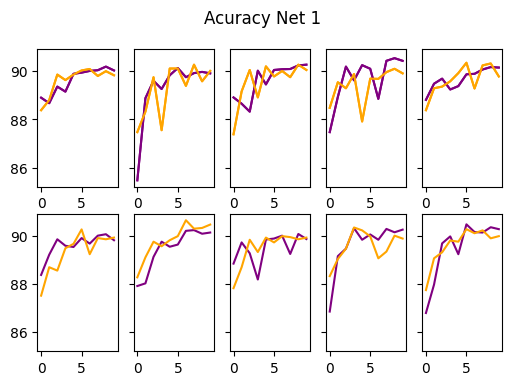

In [ ]:
#plt.rcParams['figure.figsize'] = (7, 4.8)
"""
MNIST net1: done
MNIST net2: done
MNIST net3: done

KMNIST net1: done
KMNIST net2: done
KMNIST net3: done

FMNIST net1: done
FMNIST net2: done
FMNIST net3: TODO

"""
plot_acc(x, y_graph, y2_graph, "Acuracy Net 1")

In [ ]:
#plot_acc(x, y2_graph, "Two")

In [ ]:
from scipy.ndimage.filters import gaussian_filter
print(p)
x_p = np.linspace(0, 10, 70350)
p = gaussian_filter(p, sigma=5)

plt.rcParams['figure.figsize'] = (8, 7)
plt.plot(x_p, p)
plt.title("Net 1 Training Accuracy")